In [1]:
import platform
from pathlib import Path

import os
import subprocess
import time

import numpy as np
import scipy
from scipy import optimize, interpolate
import pandas as pd # I added as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from addict import Dict
import json

# Temporary files for simulation objects
import tempfile
tempfile.tempdir = os.path.join(Path.home())

# IPython
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Image
from ipywidgets import interact, interactive
import ipywidgets as widgets

import copy
from biopandas.pdb import PandasPdb

import math

import scipy.stats as stats

In [2]:
def my_fit_function_ln_keq_2(tis, a, b):
    return np.log(a*tis**b)

def meta_correlation(a, c, d):
    return c*np.log(a) + d

def get_meta_residuals(x, a_vals, b_vals):
    c = x[0]
    d = x[1]
    return b_vals - (c*np.log(a_vals) + d)

# Remove my data from the saved files

In [3]:
# df = pd.read_csv('./lit_data/all_kprime.csv')
# df[df.data_set != 'mine'].to_csv('./lit_data/kprime_without_my_data.csv', index=False)

In [4]:
# df = pd.read_csv('./lit_data/two_params_all_data.csv')
# df[df.data_set != 'mine'].to_csv('./lit_data/two_params_without_my_data.csv', index=False)

# Literature $k'$ data

In [3]:
df_all_k = pd.read_csv('./lit_data/kprime_without_my_data.csv')
df_2_fit_parms = pd.read_csv('./lit_data/two_params_without_my_data.csv')

In [6]:
# cex_resins = list(set(df_all_k[df_all_k.iex_type == 'cex'].resin))
# cex_resins.sort()
# for r in cex_resins:
#     print(r)

In [4]:
resins_cex = list(set(df_2_fit_parms[df_2_fit_parms.iex_type=='cex'].resin))
resins_cex.sort()

resins_aex = list(set(df_2_fit_parms[df_2_fit_parms.iex_type=='aex'].resin))
resins_aex.sort()

resins = resins_aex + resins_cex

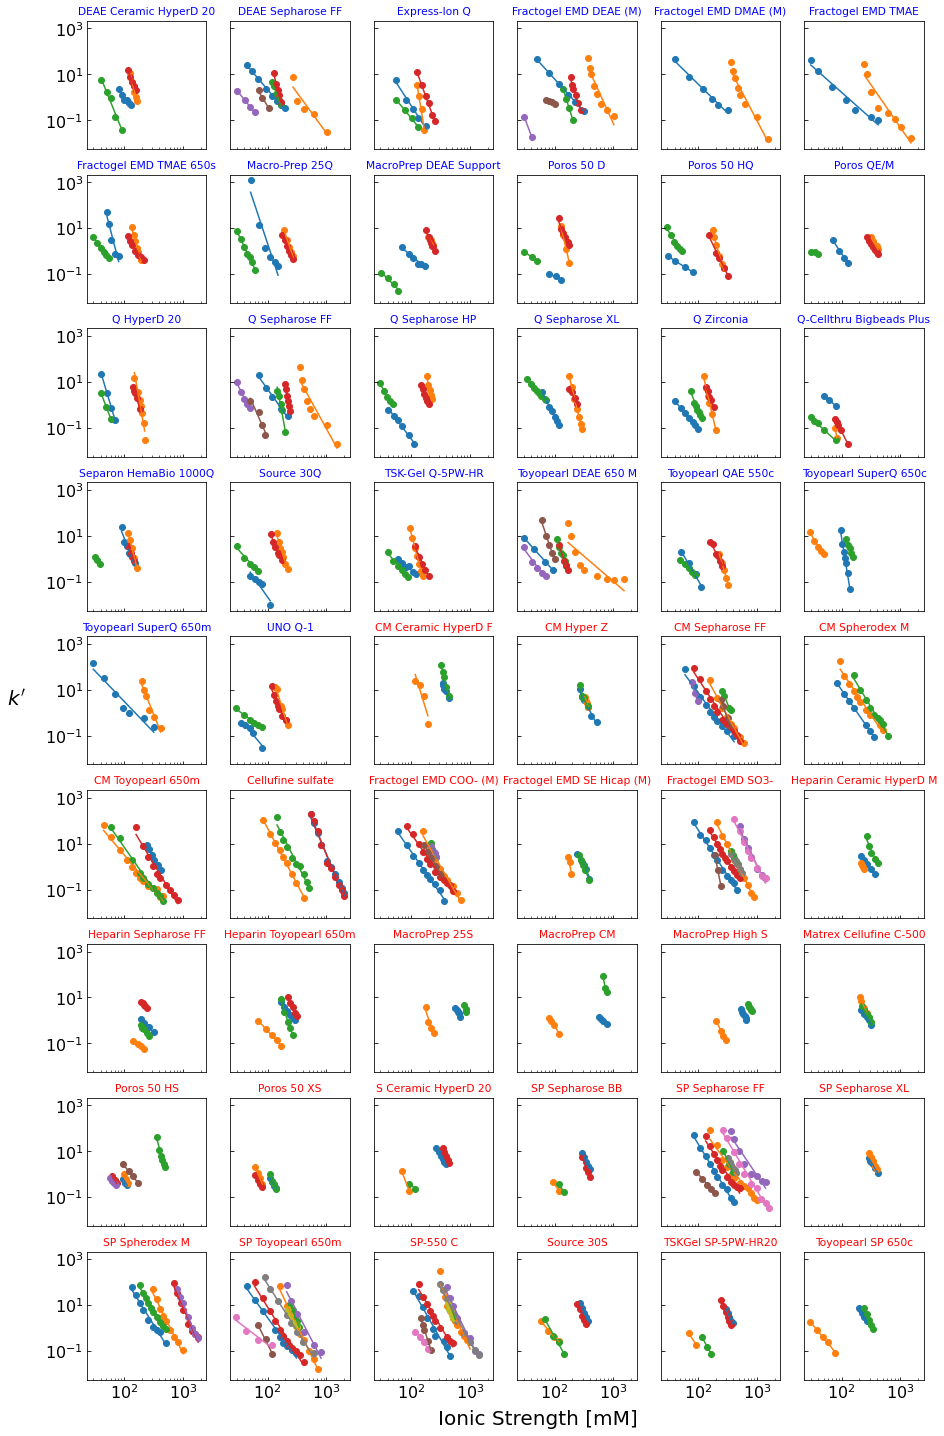

In [11]:
n_row, n_col = 9, 6
fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True)
params = {'font.weight':'normal', 'font.size':16}
plt.rcParams.update(params)
fig.set_size_inches(15, 25, forward=True)
fig.patch.set_alpha(1.0)
fig.text(0.06, 0.5, "$k'$", ha='center', fontsize=20)
fig.text(0.45, 0.1, 'Ionic Strength [mM]', fontsize=20)

title_colors = {'aex':'blue', 'cex':'red'}

for i, resin in enumerate(resins):
    row, column = math.floor(i/n_col), i%n_col
    ax[row, column].set_title(resin, {'fontsize':10.7, 'color':title_colors[df_2_fit_parms.loc[df_2_fit_parms['resin'] == resin, 'iex_type'].iloc[0]]}) # title.set_text
    ax[row, column].tick_params('both', which='major', direction='in')
    ax[row, column].tick_params('both', which='minor', direction='in')
    df = df_all_k[(df_all_k.resin==resin)]
    
    sub_pairs = set(zip(df.data_set, df.protein, df.pH))
    for (data_set, protein, pH) in sub_pairs:
        df_sub = df[(df.data_set==data_set) & (df.protein==protein) & (df.pH==pH)]
        ax[row, column].scatter(df_sub.tis_mM, df_sub.kprime)

        df_params = df_2_fit_parms[(df_2_fit_parms.protein==protein) &\
                            (df_2_fit_parms.pH==pH) &\
                            (df_2_fit_parms.resin==resin) &\
                            (df_2_fit_parms.data_set==data_set)].copy()
        df_params.reset_index(inplace=True, drop=True)
        a, b = df_params.at[0, 'a'], df_params.at[0, 'b']

        tis_vals = np.linspace(min(df_sub.tis_mM), max(df_sub.tis_mM))
        kprime_fit = [a*tis**b for tis in tis_vals]
        ax[row, column].loglog(tis_vals, kprime_fit)

fig.patch.set_alpha(1)
fig.savefig('./images/manuscript_images/lit_kprime_data.pdf', bbox_inches='tight')
fig.savefig('./images/manuscript_images/lit_kprime_data.png', bbox_inches='tight', dpi=300)

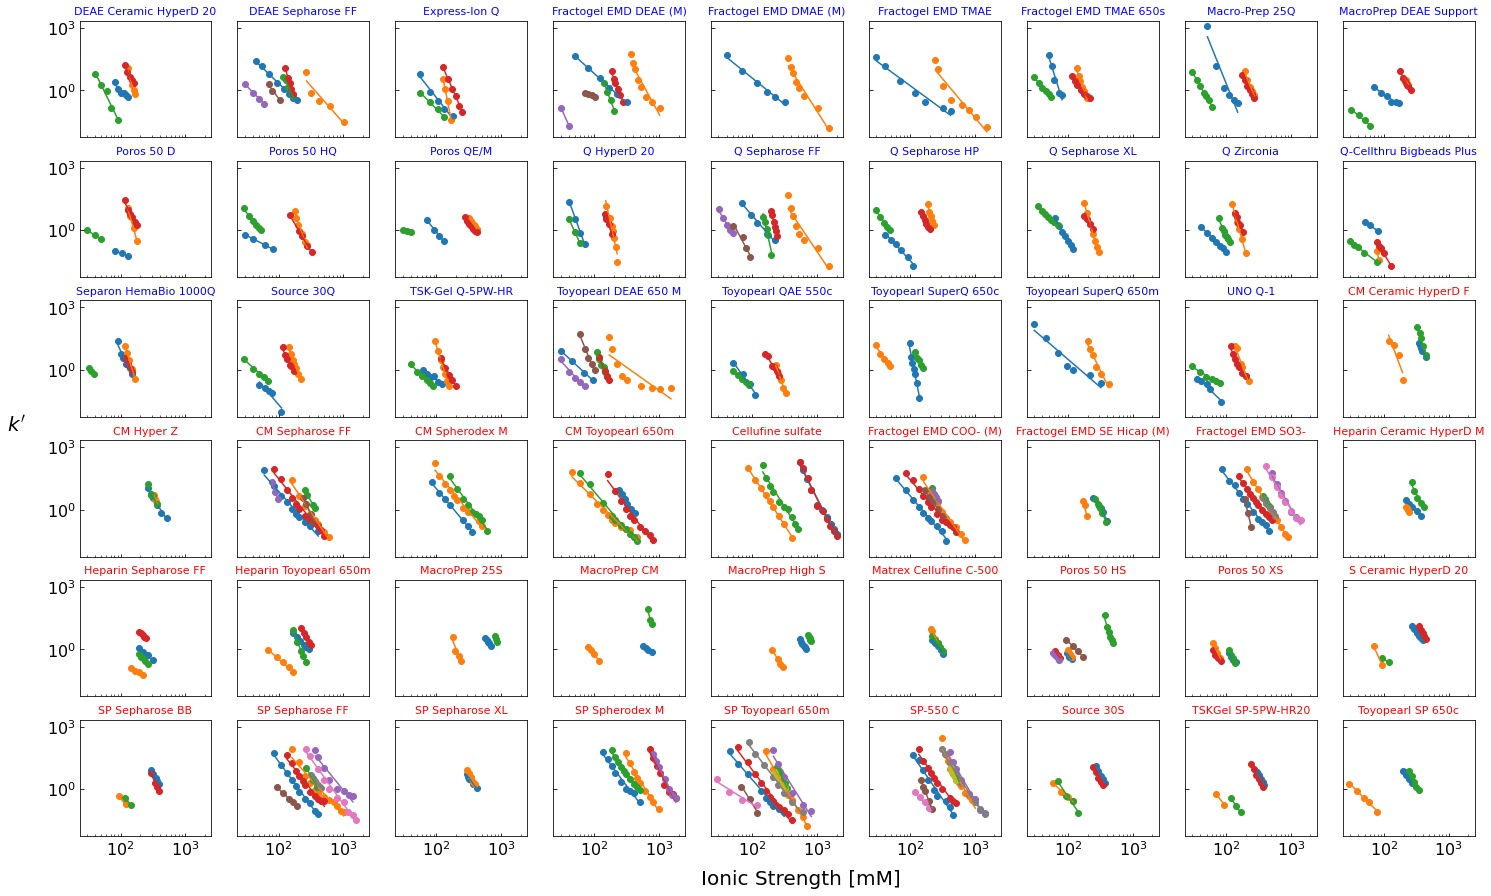

In [12]:
n_row, n_col = 6, 9
fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True)
params = {'font.weight':'normal', 'font.size':16}
plt.rcParams.update(params)
fig.set_size_inches(25, 15, forward=True)
fig.patch.set_alpha(1.0)
fig.text(0.09, 0.5, "$k'$", ha='center', fontsize=20)
fig.text(0.47, 0.08, 'Ionic Strength [mM]', fontsize=20)

title_colors = {'aex':'blue', 'cex':'red'}

for i, resin in enumerate(resins):
    row, column = math.floor(i/n_col), i%n_col
    ax[row, column].set_title(resin, {'fontsize':11, 'color':title_colors[df_2_fit_parms.loc[df_2_fit_parms['resin'] == resin, 'iex_type'].iloc[0]]}) # title.set_text
    ax[row, column].tick_params('both', which='major', direction='in')
    ax[row, column].tick_params('both', which='minor', direction='in')
    df = df_all_k[(df_all_k.resin==resin)]
    
    sub_pairs = set(zip(df.data_set, df.protein, df.pH))
    for (data_set, protein, pH) in sub_pairs:
        df_sub = df[(df.data_set==data_set) & (df.protein==protein) & (df.pH==pH)]
        ax[row, column].scatter(df_sub.tis_mM, df_sub.kprime)

        df_params = df_2_fit_parms[(df_2_fit_parms.protein==protein) &\
                            (df_2_fit_parms.pH==pH) &\
                            (df_2_fit_parms.resin==resin) &\
                            (df_2_fit_parms.data_set==data_set)].copy()
        df_params.reset_index(inplace=True, drop=True)
        a, b = df_params.at[0, 'a'], df_params.at[0, 'b']

        tis_vals = np.linspace(min(df_sub.tis_mM), max(df_sub.tis_mM))
        kprime_fit = [a*tis**b for tis in tis_vals]
        ax[row, column].loglog(tis_vals, kprime_fit)

fig.patch.set_alpha(1)
fig.savefig('./images/manuscript_images/lit_kprime_data_horizontal.pdf', bbox_inches='tight')
fig.savefig('./images/manuscript_images/lit_kprime_data_horizontal.png', bbox_inches='tight', dpi=300)

In [8]:
len(set(zip(df_all_k.protein, df_all_k.resin))), len(set(zip(df_all_k.protein, df_all_k.resin, df_all_k.pH)))

(220, 230)

In [12]:
len(set(df_all_k.resin)), len(set(df_all_k.protein)), len(set(df_all_k.pH))

(54, 13, 6)

# SDM parameter correlation

In [5]:
df_2_fit_parms = pd.read_csv('./lit_data/two_params_without_my_data.csv')
df_2_fit_parms['ln_a'] = np.log(df_2_fit_parms.a)

df_lge = pd.read_csv('./lit_data/gradient_data.csv')

In [6]:
def instantiate_fig(x=7, y=6):
    fig, ax = plt.subplots()
    fig.set_size_inches(x, y, forward=True)
    font = {'weight' : 'normal', 'size'   : 20}
    plt.rc('font', **font)
    return fig, ax

def set_layout(fig, ax, legend=False):
    if legend:
        ax.legend(loc='best', handlelength=1, frameon=False)
    fig.patch.set_alpha(1)
    plt.tight_layout()
    return

def get_reg_intervals(x, y, alpha=0.05, line_extension=0.0):
    slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment
    y_model = np.polyval([slope, intercept], x)   # modeling...

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = x.size                        # number of samples
    m = 2                             # number of parameters
    dof = n - m                       # degrees of freedom
    t = stats.t.ppf(1.0-alpha/2.0, dof) # Students statistic of interval confidence

    residual = y - y_model
    std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

    # mean squared error
    MSE = 1/n * np.sum( residual**2 )

    # to plot the adjusted model
    x_line = np.linspace(np.min(x)-line_extension, np.max(x)+line_extension, 1000)
    y_line = np.polyval([slope, intercept], x_line)

    # intervals
    ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
    pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  
    pred_err_var = (std_error**2.0) * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))
    
    return x_line, y_line, ci, pi, pred_err_var

def get_pred_err_var(x, y, x_star):
    slope, intercept = np.polyfit(x, y, 1)  
    y_model = np.polyval([slope, intercept], x)  
    residual = y - y_model

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = x.size                       
    m = 2                            
    dof = n - m   
    
    pred_err_var = (np.sum(residual**2) / dof) * (1 + 1/n + (x_star - x_mean)**2 / np.sum((x - x_mean)**2))
    return pred_err_var
    
def plot_intervals(x, y, x_line, y_line, ci, pi):
    fig, ax = instantiate_fig()
    ax.set_xlabel('$a$')
    ax.set_ylabel('$b$')
    ax.set_xscale('log')
    
    color = 'blue'
    ax.plot(np.exp(x), y, 'o', color = 'royalblue')
    ax.plot(np.exp(x_line), y_line, color = 'royalblue', linestyle='--')
    ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = 'lightcyan', label = '95% PI')
    ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = 'skyblue', label = '95% CI')
#     ax.legend(loc='upper right', fontsize=20)

    return fig, ax

def plot_intervals_reverse(x, y, x_line, y_line, ci, pi):
    fig, ax = instantiate_fig()
    ax.set_xlabel('$b$')
    ax.set_ylabel('$a$')
    ax.set_yscale('log')
    
    color = 'blue'
    ax.plot(x, np.exp(y), 'o', color = 'royalblue')
    ax.plot(x_line, np.exp(y_line), color = 'royalblue', linestyle='--')
    ax.fill_between(x_line, np.exp(y_line + pi), np.exp(y_line - pi), color = 'lightcyan', label = '95% PI')
    ax.fill_between(x_line, np.exp(y_line + ci), np.exp(y_line - ci), color = 'skyblue', label = '95% CI')
    ax.legend(loc='upper right', fontsize=20)

    return fig, ax

def plot_intervals_reverse_ln(x, y, x_line, y_line, ci, pi):
    fig, ax = instantiate_fig()
    ax.set_xlabel('$b$')
    ax.set_ylabel('$ln(a)$')
    
    color = 'blue'
    ax.plot(x, y, 'o', color = 'royalblue')
    ax.plot(x_line, y_line, color = 'royalblue', linestyle='--')
    ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% PI')
    ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% CI')
    ax.legend(loc='lower left', fontsize=16)

    return fig, ax

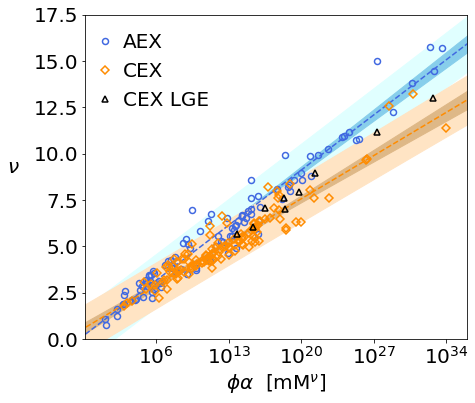

In [8]:
fig, ax = instantiate_fig()
ax.set_xlabel(r'$\phi \alpha$  [mM$^\nu$]')
ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)

ax.set_xscale('log')
ax.set_xlim(np.exp(-2), np.exp(83))
ax.set_ylim(0, 17.5)
# # Used for understanding
# ax.set_xlim(np.exp(-2), np.exp(83))
# ax.set_ylim(4.7, 5.8)
# ax.axvline(6.363078e+13, color='black')

# iex_type_list = ['cex', 'aex']
iex_type_list = ['aex', 'cex']

for iex_type in iex_type_list:
    df = df_2_fit_parms[df_2_fit_parms.iex_type==iex_type]

    data = np.zeros((len(df), 2))
    data[:,0] = df.ln_a
    data[:,1] = -1*df.b

    x = data[:,0]
    y = data[:,1]

    x_line, y_line, ci, pi, pred_err_var = get_reg_intervals(x, y, line_extension=10.0)
    
    if iex_type == 'aex':
        color_1, color_2, color_3 = 'royalblue', 'skyblue', 'lightcyan'
        marker = 'o'
    elif iex_type == 'cex':
        color_1, color_2, color_3 = 'darkorange', 'burlywood', 'bisque'
        marker = 'D'
    
    ax.plot(np.exp(x), y, marker, color = color_1, label=iex_type.upper(), 
            fillstyle='none', markeredgewidth=1.5)
    ax.plot(np.exp(x_line), y_line, color = color_1, linestyle='--')
    ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = color_3)
    ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = color_2)

ax.plot(df_lge.phi_alpha, df_lge.nu, '^', color='black', label='CEX LGE', 
       fillstyle='none', markeredgewidth=1.5)

ax.legend(loc='upper left', handlelength=0.2, frameon=False)
set_layout(fig, ax)
# fig.savefig(f'./images/manuscript_images/sdm_parameter_correlation.pdf')
# fig.savefig('./images/manuscript_images/sdm_parameter_correlation.png', dpi=300)

# Comparison in Yamamoto's regression space

Note on converting from my previous notation: nu = -b, a=phi alpha (for the k' data)


In [12]:
df_2_fit_parms = pd.read_csv('./lit_data/two_params_without_my_data.csv')
df_2_fit_parms['ln_a'] = np.log(df_2_fit_parms.a)

lys_gh_is_files = os.listdir('./lysozyme_seph_gradient_GH_results/')
dfs_grad_gh = {}
for file in lys_gh_is_files:
    dfs_grad_gh[int(file[3])] = pd.read_csv(f'./lysozyme_seph_gradient_GH_results/{file}')
    # Keys are pH values 5, 7, 9

In [13]:
df = df_2_fit_parms[df_2_fit_parms.iex_type=='cex']
c, d = np.polyfit(df.ln_a, -1*df.b, 1) # slope, intercept

eps_t = 0.897
phi = (1.0 - eps_t)/eps_t

log10_ion_str_vals = np.linspace(2, 3, 100)

In [14]:
def get_nu(alpha, c, d, phi):
    return c*np.log(alpha) + c*np.log(phi) + d

def get_alpha(nu, c, d, phi):
    return np.exp((nu - c*np.log(phi) - d)/c)

def get_m_yam(nu):
    return 1.0 + nu

def get_b_yam(alpha, nu):
    return -1.0*np.log10(alpha * (1.0 + nu))

def get_log10_gh(log10_ion_str, m_yam, b_yam):
    return m_yam*log10_ion_str + b_yam

def get_yam_lines_nu(in_val, flag='nu'):
    if flag=='nu':
        nu = in_val
        alpha = get_alpha(nu, c, d, phi)
    elif flag=='alpha':
        alpha = in_val
        nu = get_nu(alpha, c, d, phi)
    else:
        raise ValueError('Flag must be either "nu" or "alpha" ')
    m_yam = get_m_yam(nu)
    b_yam = get_b_yam(alpha, nu)
    log10_gh_vals = [get_log10_gh(log10_ion_str, m_yam, b_yam) for log10_ion_str in log10_ion_str_vals]
    return log10_ion_str_vals, log10_gh_vals

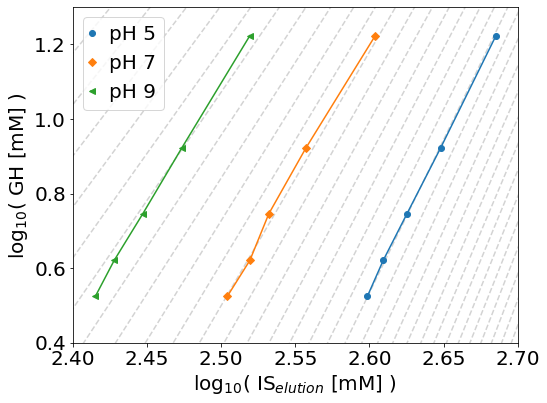

In [8]:
import itertools
marker = itertools.cycle(('o', 'D', '<', 'P', '^', 's')) 

params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.patch.set_alpha(1.0)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel(r'log$_{10}$( IS$_{elution}$ [mM] )')
ax.set_ylabel(r'log$_{10}$( GH [mM] )')
ax.set_ylim(0.4, 1.3)
ax.set_xlim(2.4, 2.7)

for nu in np.arange(2, 13, 0.2):
    log10_ion_str, log10_gh = get_yam_lines_nu(nu, flag='nu')
    ax.plot(log10_ion_str, log10_gh, '--', color='lightgrey')
    
#     # Used for understanding
#     if abs(nu - 4.8) < 0.01:
#         print(f'{nu:.2f}, {get_alpha(nu, c, d, phi):.2e}')
#         ax.plot(log10_ion_str, log10_gh, '--', color='magenta')
#     else:
#         ax.plot(log10_ion_str, log10_gh, '--', color='lightgrey')

# for alpha in np.logspace(5, 50, 100):
#     log10_ion_str, log10_gh = get_yam_lines_nu(alpha, flag='alpha')
#     ax.plot(log10_ion_str, log10_gh, '--', color='lightgrey')

for pH, df in dfs_grad_gh.items():
      ax.plot(df['logIS'], df['logGH'], marker=next(marker), label=f'pH {pH}')

ax.legend(loc='upper left', frameon=True, handlelength=0.1)
plt.tight_layout()
# fig.savefig('./images/manuscript_images/my_lge_data.pdf')
# fig.savefig('./images/manuscript_images/my_lge_data.png', dpi=300)

In [15]:
df_saleh = pd.read_csv('./lit_data/saleh/cleaned_data/saleh_data_mod_2.csv')

species_list = list(set(df_saleh['species']))
pH_list = list(set(df_saleh['pH']))

species_list.sort()
pH_list.sort()
species_name = {'hmw':'HMW', 'monomer':'Mono'}


factor = (1.0 - 0.41)/(1.0 - 0.73) # Conversion to my current interpretation of using 
                                    # eps_c in Yamamoto's GH - this needs to be 
                                    # REVISITED/confirmed
df_saleh['log(cs[mM])'] = np.log10(1e3*np.exp(df_saleh['ln(cs[M])']))
# df_saleh['log(GH[mM])'] = np.log10(1e3*np.exp(df_saleh['ln(GH[M])'])*factor)
df_saleh['log(GH[mM])'] = np.log10(1e3*np.exp(df_saleh['ln(GH[M])']))

df_saleh

,species,pH,ln(cs[M]),ln(GH[M]),log(cs[mM]),log(GH[mM])
0,monomer,5.5,-1.285893,-5.439437,2.441544,0.637683
1,monomer,5.5,-1.234776,-5.032012,2.463744,0.814625
2,monomer,5.5,-1.161725,-4.335557,2.495469,1.117092
3,monomer,5.8,-1.461633,-5.439437,2.365221,0.637683
4,monomer,5.8,-1.422374,-5.032012,2.382271,0.814625
5,monomer,5.8,-1.334926,-4.335557,2.420249,1.117092
6,monomer,6.1,-1.622976,-5.439437,2.295150,0.637683
7,monomer,6.1,-1.572284,-5.032012,2.317166,0.814625
8,monomer,6.1,-1.485682,-4.335557,2.354777,1.117092
9,hmw,5.5,-1.154193,-5.439437,2.498740,0.637683


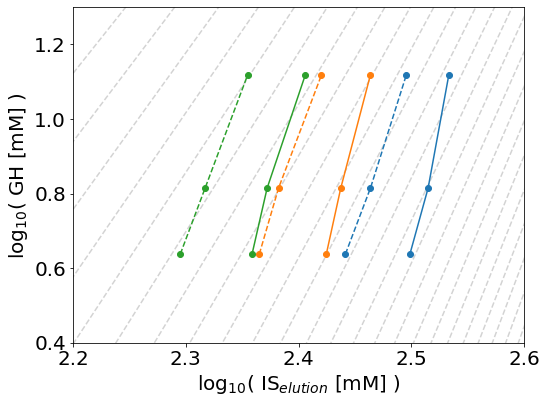

In [17]:
import itertools
marker = itertools.cycle(('o', 'D', '<', 'P', '^', 's')) 

params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.patch.set_alpha(1.0)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel(r'log$_{10}$( IS$_{elution}$ [mM] )')
ax.set_ylabel(r'log$_{10}$( GH [mM] )')
ax.set_ylim(0.4, 1.3)
ax.set_xlim(2.2, 2.6)

for nu in np.arange(2, 13, 0.2):
    log10_ion_str, log10_gh = get_yam_lines_nu(nu, flag='nu')
    ax.plot(log10_ion_str, log10_gh, '--', color='lightgrey')

for pH in pH_list:
    for species in species_list:
        df = df_saleh[(df_saleh['species'] == species) & (df_saleh['pH'] == pH)]
        label=f'{species_name[species]} pH {pH}'
        
        if species == 'hmw':  
            ax.plot(df['log(cs[mM])'], df['log(GH[mM])'], '-o', label=label)
        else:
            ax.plot(df['log(cs[mM])'], df['log(GH[mM])'], '--o', label=label,
                   color=plt.gca().lines[-1].get_color())

# ax.legend(loc='upper left', frameon=True, handlelength=0.1)
plt.tight_layout()
# fig.savefig('./images/manuscript_images/saleh_lge_data.pdf')
# fig.savefig('./images/manuscript_images/saleh_lge_data.png', dpi=300)

# For Bramie's update meeting with BMS

**Note:  first run the two cells in SDM parameter correlation above**

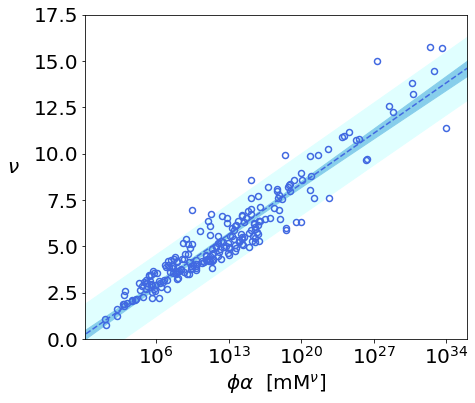

In [12]:
fig, ax = instantiate_fig()
ax.set_xlabel(r'$\phi \alpha$  [mM$^\nu$]')
ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)

ax.set_xscale('log')
ax.set_xlim(np.exp(-2), np.exp(83))
ax.set_ylim(0, 17.5)

df = df_2_fit_parms

data = np.zeros((len(df), 2))
data[:,0] = df.ln_a
data[:,1] = -1*df.b

x = data[:,0]
y = data[:,1]

x_line, y_line, ci, pi, pred_err_var = get_reg_intervals(x, y, line_extension=10.0)

color_1, color_2, color_3 = 'royalblue', 'skyblue', 'lightcyan'
marker = 'o'

ax.plot(np.exp(x), y, marker, color = color_1, label=iex_type.upper(), 
        fillstyle='none', markeredgewidth=1.5)
ax.plot(np.exp(x_line), y_line, color = color_1, linestyle='--')
ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = color_3)
ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = color_2)

set_layout(fig, ax)
# fig.savefig(f'./images/manuscript_images/sdm_parameter_correlation.pdf')
# fig.savefig('./images/manuscript_images/sdm_parameter_correlation_one_curve.png', dpi=300)

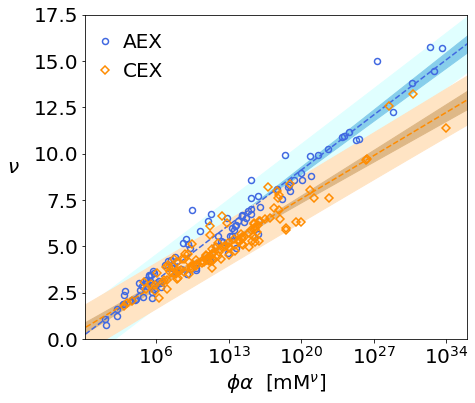

In [13]:
fig, ax = instantiate_fig()
ax.set_xlabel(r'$\phi \alpha$  [mM$^\nu$]')
ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)

ax.set_xscale('log')
ax.set_xlim(np.exp(-2), np.exp(83))
ax.set_ylim(0, 17.5)

# iex_type_list = ['cex', 'aex']
iex_type_list = ['aex', 'cex']

for iex_type in iex_type_list:
    df = df_2_fit_parms[df_2_fit_parms.iex_type==iex_type]

    data = np.zeros((len(df), 2))
    data[:,0] = df.ln_a
    data[:,1] = -1*df.b

    x = data[:,0]
    y = data[:,1]

    x_line, y_line, ci, pi, pred_err_var = get_reg_intervals(x, y, line_extension=10.0)
    
    if iex_type == 'aex':
        color_1, color_2, color_3 = 'royalblue', 'skyblue', 'lightcyan'
        marker = 'o'
    elif iex_type == 'cex':
        color_1, color_2, color_3 = 'darkorange', 'burlywood', 'bisque'
        marker = 'D'
    
    ax.plot(np.exp(x), y, marker, color = color_1, label=iex_type.upper(), 
            fillstyle='none', markeredgewidth=1.5)
    ax.plot(np.exp(x_line), y_line, color = color_1, linestyle='--')
    ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = color_3)
    ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = color_2)

# ax.plot(df_lge.phi_alpha, df_lge.nu, '^', color='black', label='CEX LGE', 
#        fillstyle='none', markeredgewidth=1.5)

ax.legend(loc='upper left', handlelength=0.2, frameon=False)
set_layout(fig, ax)
# fig.savefig(f'./images/manuscript_images/sdm_parameter_correlation.pdf')
# fig.savefig('./images/manuscript_images/sdm_parameter_correlation_two_curves.png', dpi=300)

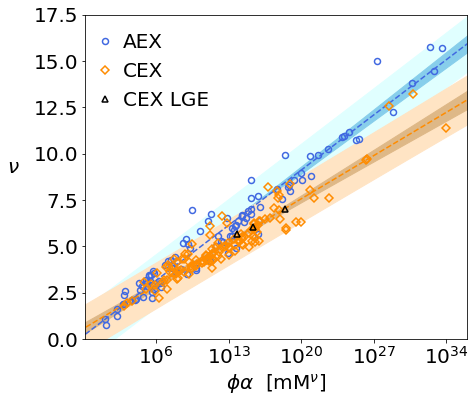

In [14]:
fig, ax = instantiate_fig()
ax.set_xlabel(r'$\phi \alpha$  [mM$^\nu$]')
ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)

ax.set_xscale('log')
ax.set_xlim(np.exp(-2), np.exp(83))
ax.set_ylim(0, 17.5)

# iex_type_list = ['cex', 'aex']
iex_type_list = ['aex', 'cex']

for iex_type in iex_type_list:
    df = df_2_fit_parms[df_2_fit_parms.iex_type==iex_type]

    data = np.zeros((len(df), 2))
    data[:,0] = df.ln_a
    data[:,1] = -1*df.b

    x = data[:,0]
    y = data[:,1]

    x_line, y_line, ci, pi, pred_err_var = get_reg_intervals(x, y, line_extension=10.0)
    
    if iex_type == 'aex':
        color_1, color_2, color_3 = 'royalblue', 'skyblue', 'lightcyan'
        marker = 'o'
    elif iex_type == 'cex':
        color_1, color_2, color_3 = 'darkorange', 'burlywood', 'bisque'
        marker = 'D'
    
    ax.plot(np.exp(x), y, marker, color = color_1, label=iex_type.upper(), 
            fillstyle='none', markeredgewidth=1.5)
    ax.plot(np.exp(x_line), y_line, color = color_1, linestyle='--')
    ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = color_3)
    ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = color_2)

ax.plot(df_lge[df_lge.data_set=='mine'].phi_alpha, df_lge[df_lge.data_set=='mine'].nu, 
        '^', color='black', label='CEX LGE', fillstyle='none', markeredgewidth=1.5)

ax.legend(loc='upper left', handlelength=0.2, frameon=False)
set_layout(fig, ax)
# fig.savefig(f'./images/manuscript_images/sdm_parameter_correlation.pdf')
# fig.savefig('./images/manuscript_images/sdm_parameter_correlation_two_curves_our_lge.png', dpi=300)

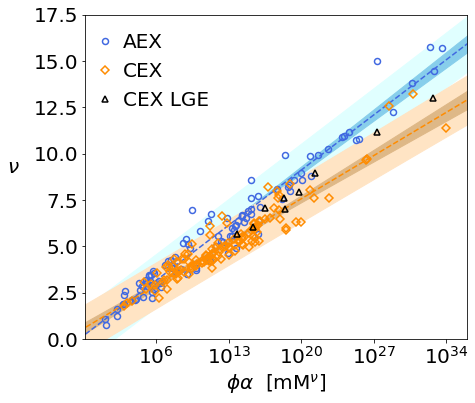

In [16]:
fig, ax = instantiate_fig()
ax.set_xlabel(r'$\phi \alpha$  [mM$^\nu$]')
ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)

ax.set_xscale('log')
ax.set_xlim(np.exp(-2), np.exp(83))
ax.set_ylim(0, 17.5)

# iex_type_list = ['cex', 'aex']
iex_type_list = ['aex', 'cex']

for iex_type in iex_type_list:
    df = df_2_fit_parms[df_2_fit_parms.iex_type==iex_type]

    data = np.zeros((len(df), 2))
    data[:,0] = df.ln_a
    data[:,1] = -1*df.b

    x = data[:,0]
    y = data[:,1]

    x_line, y_line, ci, pi, pred_err_var = get_reg_intervals(x, y, line_extension=10.0)
    
    if iex_type == 'aex':
        color_1, color_2, color_3 = 'royalblue', 'skyblue', 'lightcyan'
        marker = 'o'
    elif iex_type == 'cex':
        color_1, color_2, color_3 = 'darkorange', 'burlywood', 'bisque'
        marker = 'D'
    
    ax.plot(np.exp(x), y, marker, color = color_1, label=iex_type.upper(), 
            fillstyle='none', markeredgewidth=1.5)
    ax.plot(np.exp(x_line), y_line, color = color_1, linestyle='--')
    ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = color_3)
    ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = color_2)

ax.plot(df_lge[df_lge.data_set=='mine'].phi_alpha, df_lge[df_lge.data_set=='mine'].nu, 
        '^', color='black', label='CEX LGE', fillstyle='none', markeredgewidth=1.5)
ax.plot(df_lge[df_lge.data_set=='saleh'].phi_alpha, df_lge[df_lge.data_set=='saleh'].nu, 
        '^', color='black', fillstyle='none', markeredgewidth=1.5)

ax.legend(loc='upper left', handlelength=0.2, frameon=False)
set_layout(fig, ax)
# fig.savefig(f'./images/manuscript_images/sdm_parameter_correlation.pdf')
# fig.savefig('./images/manuscript_images/sdm_parameter_correlation_two_curves_all_lge.png', dpi=300)

# Comparison with results from the anisotropic, approximate nonlinear numerical Derjaguin spherical NS-BIM model

In [17]:
# AEX
protein_list = ['adh', 'blg', 'cat', 'ova']
resins = ['phq', 'pxq']

temp = []
for res in resins:
    df = pd.read_csv('ns_bim_spherical_pqr/Keq_predictions/Keq_predictions_' + res + '_with_kprime.csv')
    for protein in protein_list:
        df_temp = df[df['protein'] == protein].copy()
        df_temp.rename(columns={'IS(M)': 'IS (M)'}, inplace=True)
        keq_fit_params = optimize.curve_fit(my_fit_function_ln_keq_2, df_temp['IS (M)']*1e3, np.log(df_temp['k_prime']), p0=(1, -50), maxfev=10000)
        temp.append([res, protein, keq_fit_params[0][0], keq_fit_params[0][1]])

df_pred = pd.DataFrame(temp, columns=['resin', 'protein', 'a', 'b'])

# CEX
cex_pH = [5, 7, 9]
temp = []
for pH in cex_pH:
    df = pd.read_csv(f'ns_bim_spherical_pqr/Keq_predictions/sep_lys_pH_{pH}_with_kprime.csv')
    keq_fit_params = optimize.curve_fit(my_fit_function_ln_keq_2, df['IS_M']*1e3, np.log(df['k_prime']), p0=(1, -50), maxfev=10000)
    temp.append([f'seph_{pH}', 'lys', keq_fit_params[0][0], keq_fit_params[0][1]])

df_temp = pd.DataFrame(temp, columns=['resin', 'protein', 'a', 'b'])
df_pred = pd.concat([df_pred, df_temp])

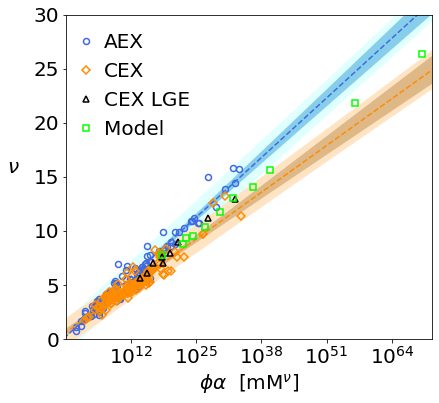

In [18]:
fig, ax = instantiate_fig(x=6.5)
ax.set_xlabel(r'$\phi \alpha$  [mM$^\nu$]')
ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)

ax.set_xscale('log')
ax.set_xlim(np.exp(-2), 1e72)
ax.set_ylim(0, 30)

# iex_type_list = ['cex', 'aex']
iex_type_list = ['aex', 'cex']

for iex_type in iex_type_list:
    df = df_2_fit_parms[df_2_fit_parms.iex_type==iex_type]

    data = np.zeros((len(df), 2))
    data[:,0] = df.ln_a
    data[:,1] = -1*df.b

    x = data[:,0]
    y = data[:,1]

    x_line, y_line, ci, pi, pred_err_var = get_reg_intervals(x, y, line_extension=100.0)
    
    if iex_type == 'aex':
        color_1, color_2, color_3 = 'royalblue', 'skyblue', 'lightcyan'
        marker = 'o'
    elif iex_type == 'cex':
        color_1, color_2, color_3 = 'darkorange', 'burlywood', 'bisque'
        marker = 'D'
    
    ax.plot(np.exp(x), y, marker, color = color_1, label=iex_type.upper(), 
            fillstyle='none', markeredgewidth=1.5)
    ax.plot(np.exp(x_line), y_line, color = color_1, linestyle='--')
    ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = color_3)
    ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = color_2)

ax.plot(df_lge[df_lge.data_set=='mine'].phi_alpha, df_lge[df_lge.data_set=='mine'].nu, 
        '^', color='black', label='CEX LGE', fillstyle='none', markeredgewidth=1.5)

ax.plot(df_lge[df_lge.data_set=='saleh'].phi_alpha, df_lge[df_lge.data_set=='saleh'].nu, 
        '^', color='black', fillstyle='none', markeredgewidth=1.5)

ax.plot(df_pred.a, -1.0*df_pred.b, 's', color='lime', label='Model', fillstyle='none', markeredgewidth=1.5)

ax.legend(loc='upper left', handlelength=0.2, frameon=False)
set_layout(fig, ax)
# fig.savefig('./images/manuscript_images/sdm_parameter_correlation_two_curves_all_lge_with_electrostatics.png', dpi=300, bbox_inches='tight')
# fig.savefig('./images/manuscript_images/sdm_parameter_correlation_two_curves_all_lge_with_electrostatics.pdf', bbox_inches='tight')

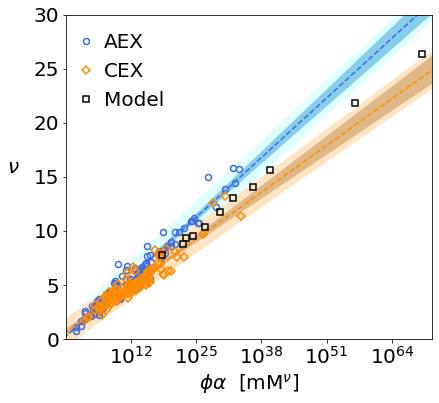

In [19]:
fig, ax = instantiate_fig(x=6.5)
ax.set_xlabel(r'$\phi \alpha$  [mM$^\nu$]')
ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)

ax.set_xscale('log')
ax.set_xlim(np.exp(-2), 1e72)
ax.set_ylim(0, 30)

# iex_type_list = ['cex', 'aex']
iex_type_list = ['aex', 'cex']

for iex_type in iex_type_list:
    df = df_2_fit_parms[df_2_fit_parms.iex_type==iex_type]

    data = np.zeros((len(df), 2))
    data[:,0] = df.ln_a
    data[:,1] = -1*df.b

    x = data[:,0]
    y = data[:,1]

    x_line, y_line, ci, pi, pred_err_var = get_reg_intervals(x, y, line_extension=100.0)
    
    if iex_type == 'aex':
        color_1, color_2, color_3 = 'royalblue', 'skyblue', 'lightcyan'
        marker = 'o'
    elif iex_type == 'cex':
        color_1, color_2, color_3 = 'darkorange', 'burlywood', 'bisque'
        marker = 'D'
    
    ax.plot(np.exp(x), y, marker, color = color_1, label=iex_type.upper(), 
            fillstyle='none', markeredgewidth=1.5)
    ax.plot(np.exp(x_line), y_line, color = color_1, linestyle='--')
    ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = color_3)
    ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = color_2)

# ax.plot(df_lge[df_lge.data_set=='mine'].phi_alpha, df_lge[df_lge.data_set=='mine'].nu, 
#         '^', color='black', label='CEX LGE', fillstyle='none', markeredgewidth=1.5)

# ax.plot(df_lge[df_lge.data_set=='saleh'].phi_alpha, df_lge[df_lge.data_set=='saleh'].nu, 
#         '^', color='black', fillstyle='none', markeredgewidth=1.5)

ax.plot(df_pred.a, -1.0*df_pred.b, 's', color='black', label='Model', fillstyle='none', markeredgewidth=1.5)

ax.legend(loc='upper left', handlelength=0.2, frameon=False)
set_layout(fig, ax)
fig.savefig('./images/manuscript_images/sdm_parameter_correlation_two_curves_all_lge_with_electrostatics.png', dpi=300, bbox_inches='tight')
fig.savefig('./images/manuscript_images/sdm_parameter_correlation_two_curves_all_lge_with_electrostatics.pdf', bbox_inches='tight')

# Table for publication

In [72]:
refs = {
    'dephillips_cex':"""P. DePhillips, A. M. Lenhoff, Determinants of protein retention characteristics on cation-exchange adsorbents, Journal of Chromatography A 933 (2001) 57–72. doi:10.1016/S0021-9673(01)01275-4.""",
    'kumar':"""V. Kumar, S. Leweke, E. von Lieres, A. S. Rathore, Mechanistic modeling of ion-exchange process chromatography of charge variants of monoclonal antibody products, Journal of Chromatography A 1426 (2015) 140–153. doi:10.1016/j.chroma.2015.11.062.""",
    'staby_1':"""A. Staby, I. H. Jensen, I. Mollerup, Comparison of chromatographic ion-exchange resins I. Strong anion-exchange resins, Journal of Chromatography A 897 (2000) 99–111. doi:10.1016/s0021-9673(00)00780-9.""",
    'staby_2':"""A. Staby, I. H. Jensen, Comparison of chromatographic ion-exchange resins II. More strong anion-exchange resins, Journal of Chromatography A 908 (2001) 149–161. doi:10.1016/S0021-9673(00)00999-7.""",
    'staby_3':"""A. Staby, M.-B. Sand, R. G. Hansen, J. H. Jacobsen, L. A. Andersen, M. Gerstenberg, U. K. Bruus, I. H. Jensen, Comparison of chromatographic ion-exchange resins: III. Strong cation-exchange resins, Journal of Chromatography A 1034 (2004) 85–97. doi:10.1016/j.chroma.2004.01.026.""",
    'staby_4':"""A. Staby, M.-B. Sand, R. G. Hansen, J. H. Jacobsen, L. A. Andersen, M. Gerstenberg, U. K. Bruus, I. H. Jensen, Comparison of chromatographic ion-exchange resins: IV. Strong and weak cation-exchange resins and heparin resins, Journal of Chromatography A 1069 (2005) 65–77. doi:10.1016/j.chroma.2004.11.094.""",
    'staby_5':"""A. Staby, J. H. Jacobsen, R. G. Hansen, U. K. Bruus, I. H. Jensen, Comparison of chromatographic ion-exchange resins. V. Strong and weak cation-exchange resins, Journal of Chromatography A 1118 (2006) 168–179. doi:10.1016/j.chroma.2006.03.116.""",
    'staby_6':"""A. Staby, R. H. Jensen, M. Bensch, J. Hubbuch, D. L. Dünweber, J. Krarup, J. Nielsen, M. Lund, S. Kidal, T. B. Hansen, I. H. Jensen, Comparison of chromatographic ion-exchange resins. VI. Weak anion-exchange resins, Journal of Chromatography A 1164 (2007) 82–94. doi:10.1016/j.chroma.2007.06.048.""",
    'dephillips_fgf':"""P. DePhillips, A. M. Lenhoff, Relative retention of the fibroblast growth factors FGF-1 and FGF-2 on strong cation-exchange sorbents, Journal of Chromatography A 1036 (2004) 51–60. doi:10.1016/j.chroma.2004.01.012.""",
    'bai':"""J. Z. Bai, Characterization of protein retention and transport in anion exchange chromatography, Master’s thesis, University of Delaware,Newark, DE, USA (1999).""",
}

staby_1_resins = ['Macro-Prep 25Q', 'TSK-Gel Q-5PW-HR', 'Poros QE/M', 
                  'Q Sepharose FF', 'Q HyperD 20', 'Q Zirconia', 'Source 30Q',
                  'Fractogel EMD TMAE 650s', 'Express-Ion Q',]
staby_2_resins = ['Q Sepharose XL', 'UNO Q-1', 'Poros 50 HQ', 'Toyopearl QAE 550c',
                  'Separon HemaBio 1000Q', 'Q-Cellthru Bigbeads Plus',
                  'Q Sepharose HP', 'Toyopearl SuperQ 650c',]
staby_3_resins = ['SP Sepharose XL', 'Poros 50 HS', 'SP-550 C', 
                  'SP Sepharose BB', 'Source 30S', 'TSKGel SP-5PW-HR20',
                 'Toyopearl SP 650c',]
staby_4_resins = ['Heparin Sepharose FF', 'SP Sepharose FF', 'CM Sepharose FF',
                  'Heparin Toyopearl 650m', 'SP Toyopearl 650m', 
                  'CM Toyopearl 650m', 'S Ceramic HyperD 20', 
                  'CM Ceramic HyperD F', 'Heparin Ceramic HyperD M',]
staby_5_resins = ['Fractogel EMD SO3-', 'Fractogel EMD SE Hicap (M)',
                  'Fractogel EMD COO- (M)', 'MacroPrep 25S', 'MacroPrep High S',
                  'MacroPrep CM', 'CM Hyper Z', 'Matrex Cellufine C-500',]
staby_6_resins = ['DEAE Sepharose FF', 'Poros 50 D', 'Fractogel EMD DEAE (M)',
                  'MacroPrep DEAE Support', 'DEAE Ceramic HyperD 20',
                  'Toyopearl DEAE 650 M',]

In [88]:
df = pd.read_csv('./lit_data/kprime_without_my_data.csv')

for i, cont in df.iterrows():
    # Complete the pH entry
    if cont.data_set == 'bai':
        df.at[i, 'pH'] = 7.0
    
    # Capitalize iex types
    df.at[i, 'iex_type'] = cont.iex_type.upper()
    
    # Clean up the protein name text
    if 'mAb' == cont.protein[:3] or 'FGF' == cont.protein[:3]:
        pass
    elif 'alpha-chymotrypsinogen A' == cont.protein:
        df.at[i, 'protein'] = 'Alpha chymotrypsinogen A'
    elif 'alpha-lactalbumin' == cont.protein:
        df.at[i, 'protein'] = 'Alpha lactalbumin'
    elif 'anti-FVII mAb' == cont.protein:
        df.at[i, 'protein'] = 'Anti-FVII mAb'
    elif 'cytochrome c' == cont.protein:
        df.at[i, 'protein'] = 'Cytochrome C'
    else:
        df.at[i, 'protein'] = cont.protein.capitalize()
        
    # Add the reference
    if cont.data_set == 'bai' or cont.data_set == 'kumar':
        df.at[i, 'reference'] = refs[cont.data_set]
    elif cont.data_set == 'DePhillips':
        if 'FGF' in cont.protein:
            df.at[i, 'reference'] = refs['dephillips_fgf']
        else:
            df.at[i, 'reference'] = refs['dephillips_cex']
    elif cont.data_set == 'Staby':
        if cont.resin in staby_1_resins:
            df.at[i, 'reference'] = refs['staby_1']
        elif cont.resin in staby_2_resins:
            df.at[i, 'reference'] = refs['staby_2']
        elif cont.resin in staby_3_resins:
            df.at[i, 'reference'] = refs['staby_3']
        elif cont.resin in staby_4_resins:
            df.at[i, 'reference'] = refs['staby_4']
        elif cont.resin in staby_5_resins:
            df.at[i, 'reference'] = refs['staby_5']
        elif cont.resin in staby_6_resins:
            df.at[i, 'reference'] = refs['staby_6']
    else:
        raise('Problem')
        
df.drop(columns=['data_set'], inplace=True)
df.columns=['IEX type', 'Resin', 'Protein', 'pH', 'Total ionic strength [mM]',
           'k\'', 'Reference']
df.sort_values(by=['IEX type', 'Reference', 'Resin', 'Protein', 'pH', 
                   'Total ionic strength [mM]'])
df.to_excel('./lit_data/kprime_table_for_publication.xlsx', index=False)

In [89]:
df

,IEX type,Resin,Protein,pH,Total ionic strength [mM],k',Reference
0,CEX,SP Sepharose FF,Alpha chymotrypsinogen A,7.0,85.000,51.829281,"P. DePhillips, A. M. Lenhoff, Determinants of ..."
1,CEX,SP Sepharose FF,Alpha chymotrypsinogen A,7.0,110.000,14.542370,"P. DePhillips, A. M. Lenhoff, Determinants of ..."
2,CEX,SP Sepharose FF,Alpha chymotrypsinogen A,7.0,135.000,6.201620,"P. DePhillips, A. M. Lenhoff, Determinants of ..."
3,CEX,SP Sepharose FF,Alpha chymotrypsinogen A,7.0,160.000,2.724929,"P. DePhillips, A. M. Lenhoff, Determinants of ..."
4,CEX,SP Sepharose FF,Alpha chymotrypsinogen A,7.0,185.000,1.369794,"P. DePhillips, A. M. Lenhoff, Determinants of ..."
...,...,...,...,...,...,...,...
1322,CEX,Poros 50 XS,mAb main variant,6.5,139.669,0.259259,"V. Kumar, S. Leweke, E. von Lieres, A. S. Rath..."
1323,CEX,Poros 50 XS,mAb main variant,7.0,61.891,0.925524,"V. Kumar, S. Leweke, E. von Lieres, A. S. Rath..."
1324,CEX,Poros 50 XS,mAb main variant,7.0,67.934,0.570307,"V. Kumar, S. Leweke, E. von Lieres, A. S. Rath..."
1325,CEX,Poros 50 XS,mAb main variant,7.0,74.172,0.383470,"V. Kumar, S. Leweke, E. von Lieres, A. S. Rath..."
